# LGBM

## 라이브러리 설치

In [25]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [26]:
!pip install lightgbm

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 라이브러리 import

In [28]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.preprocessing import OneHotEncoder

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

In [29]:
# seed 고정
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

## 데이터 preprocessing

In [34]:
train_df = pd.read_csv('/content/drive/MyDrive/Aimers/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Aimers/data/test.csv')

In [35]:
# 값이 1인 항목의 이름 추출
to_drop = train_df['배란 유도 유형'].value_counts()[train_df['배란 유도 유형'].value_counts() == 1].index

# 해당 항목 제거
train_df = train_df[~train_df['배란 유도 유형'].isin(to_drop)]

In [36]:
pd.crosstab(train_df['배란 유도 유형'], train_df['임신 성공 여부'], normalize='index')

임신 성공 여부,0,1
배란 유도 유형,,
기록되지 않은 시행,0.731593,0.268407
알 수 없음,0.773245,0.226755


In [37]:
# 기록되지 않은 시행 -> 고강도 유도
# 알 수 없음, 배란 자극 여부 0 -> 유도 안함
# 알 수 없음, 배란 자극 여부 1 -> 저강도 유도
train_df['배란 유도 유형'] = train_df['배란 유도 유형'].replace('기록되지 않은 시행', '고강도 유도')
train_df.loc[(train_df['배란 자극 여부'] == 0)&(train_df['배란 유도 유형']=='알 수 없음'), '배란 유도 유형'] = '유도 안함'
train_df.loc[(train_df['배란 자극 여부'] == 1)&(train_df['배란 유도 유형']=='알 수 없음'), '배란 유도 유형'] = '저강도 유도'

test_df['배란 유도 유형'] = test_df['배란 유도 유형'].replace('기록되지 않은 시행', '고강도 유도')
test_df.loc[(test_df['배란 자극 여부'] == 0)&(test_df['배란 유도 유형']=='알 수 없음'), '배란 유도 유형'] = '유도 안함'
test_df.loc[(test_df['배란 자극 여부'] == 1)&(test_df['배란 유도 유형']=='알 수 없음'), '배란 유도 유형'] = '저강도 유도'

In [38]:
pd.crosstab(train_df['배란 유도 유형'], train_df['임신 성공 여부'], normalize='index')

임신 성공 여부,0,1
배란 유도 유형,,
고강도 유도,0.731593,0.268407
유도 안함,0.768348,0.231652
저강도 유도,0.860621,0.139379


In [ ]:
for i in range(1, 68):
    print(i)
    display(train_df.iloc[:, i].value_counts(dropna=False))

    temp_col = train_df.iloc[:, i].fillna('NaN')  # Replace NaN with a string to include in crosstab
    crosstab_result = pd.crosstab(temp_col, train_df['임신 성공 여부'], normalize='index')

    display(crosstab_result)
    print('\n')

In [ ]:
# ID 분리
test_ids = test_df['ID']  # ID 컬럼 따로 저장
train_df.drop(columns=['ID'], inplace=True)
test_df.drop(columns=['ID'], inplace=True)

In [ ]:
# 값의 공백 제거
train_df['특정 시술 유형'] = train_df['특정 시술 유형'].str.replace(' ', '')
test_df['특정 시술 유형'] = test_df['특정 시술 유형'].str.replace(' ', '')

# 특정 값 치환
train_df['특정 시술 유형'] = train_df['특정 시술 유형'].replace({
    'ICSI/BLASTOCYST:ICSI': 'ICSI/BLASTOCYST',
    'ICSI/AH:Unknown': 'ICSI/AH'
})

test_df['특정 시술 유형'] = test_df['특정 시술 유형'].replace({
    'ICSI/BLASTOCYST:ICSI': 'ICSI/BLASTOCYST',
    'ICSI/AH:Unknown': 'ICSI/AH'
})

train_df['특정 시술 유형'] = train_df['특정 시술 유형'].fillna('Unknown')
test_df['특정 시술 유형'] = test_df['특정 시술 유형'].fillna('Unknown')

# 특정 컬럼 먼저 대체
s_col = ['PGD 시술 여부', '착상 전 유전 검사 사용 여부', 'PGS 시술 여부']
train_df[s_col] = train_df[s_col].fillna(0)
test_df[s_col] = test_df[s_col].fillna(0)

# IVF가 아닌 DI의 경우 결측치 대체
# 설문 조사에서 DI의 경우 대답할 필요가 없는 항목들이 결측치로 들어간 듯
columns_to_update = ['단일 배아 이식 여부', '착상 전 유전 진단 사용 여부', '배아 생성 주요 이유',
                     '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수',
                     '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수','미세주입 후 저장된 배아 수',
                     '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
                     '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수',
                     '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부']

# Process train_df
for column in columns_to_update:
    if train_df[column].dtype == 'object':
        # object 타입이면 'Not Answer(DI)'로 채우기
        train_df[column] = train_df[column].fillna('Not Answer(DI)')
    elif train_df[column].dtype in ['float64', 'int64']:
        # 숫자 타입이면 0로 채우기
        train_df[column] = train_df[column].fillna(0)

# Process test_df
for column in columns_to_update:
    if test_df[column].dtype == 'object':
        # object 타입이면 'Not Answer(DI)'로 채우기
        test_df[column] = test_df[column].fillna('Not Answer(DI)')
    elif test_df[column].dtype in ['float64', 'int64']:
        # 숫자 타입이면 0로 채우기
        test_df[column] = test_df[column].fillna(0)

# Date 컬럼 -1 대체
d_col = ['난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일']
train_df[d_col] = train_df[d_col].fillna(0)
test_df[d_col] = test_df[d_col].fillna(0)

In [ ]:
'''# 횟수, 회 타입 변경
int_col = ['총 시술 횟수','클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수',
           '총 임신 횟수', 'IVF 임신 횟수','DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수',
           'DI 출산 횟수']

for col in int_col:
    train_df[col] = train_df[col].astype(str).str.extract('(\d+)').astype(int)
    test_df[col] = test_df[col].astype(str).str.extract('(\d+)').astype(int)'''

In [ ]:
# 값이 1인 항목의 이름 추출
to_drop = train_df['배란 유도 유형'].value_counts()[train_df['배란 유도 유형'].value_counts() == 1].index

# 해당 항목 제거
train_df = train_df[~train_df['배란 유도 유형'].isin(to_drop)]

In [ ]:
# fillna(100)
mi_col = ['임신 시도 또는 마지막 임신 경과 연수']
train_df[mi_col] = train_df[mi_col].fillna(100)
test_df[mi_col] = test_df[mi_col].fillna(100)

In [ ]:
# 조건 2: 난자 출처 == "본인 제공" → 난자 기증자 나이를 시술 당시 나이로 설정
condition2 = (train_df['난자 출처'] == "본인 제공")
train_df.loc[condition2, '난자 기증자 나이'] = train_df.loc[condition2, '시술 당시 나이']

condition2_t = (test_df['난자 출처'] == "본인 제공")
test_df.loc[condition2_t, '난자 기증자 나이'] = test_df.loc[condition2_t, '시술 당시 나이']

In [ ]:
#결측치 많은 컬럼 drop
isna_col = ['정자 기증자 나이', '난자 채취 경과일', '난자 해동 경과일']

train_df.drop(isna_col, axis=1, inplace=True)
test_df.drop(isna_col, axis=1, inplace=True)

# 거의 단일값 컬럼 drop
del_col = ['불임 원인 - 자궁경부 문제', '불임 원인 - 여성 요인', '불임 원인 - 정자 농도',
           '불임 원인 - 정자 형태', '불임 원인 - 정자 운동성', '불임 원인 - 정자 면역학적 요인']

train_df.drop(del_col, axis=1, inplace=True)
test_df.drop(del_col, axis=1, inplace=True)

## 모델링

In [ ]:
# 범주형 변수 지정 (CatBoost에서 처리하도록 설정)
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

# 범주형 변수를 category 타입으로 변환
for col in categorical_features:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = test_df[col].astype("category")  # 테스트 데이터도 변환

In [ ]:
# 타겟 분리
y_train = train_df['임신 성공 여부']
X_train = train_df.drop(columns=['임신 성공 여부'])
X_test = test_df.copy()

## 클래스 가중치 계산
class_counts = y_train.value_counts()
pos_weight = class_counts[0] / class_counts[1]

## K-Fold 검증 (가중치 적용)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'random_state': 42
}

f1_scores, auc_scores, acc_scores = [], [], []
all_y_pred_proba = []
all_y_true = []
models = []  # 각 Fold 모델 저장
test_pred_proba_list = []  # 테스트 데이터 예측 저장

for train_idx, valid_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    # LightGBM 데이터셋 생성 시 categorical_feature 설정
    lgb_train = lgb.Dataset(X_tr, label=y_tr, weight=y_tr.map({0: 1, 1: pos_weight}), categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(X_val, label=y_val, weight=y_val.map({0: 1, 1: pos_weight}), categorical_feature=categorical_features)

    model = lgb.train(params, lgb_train, valid_sets=[lgb_valid], callbacks=[early_stopping(50), log_evaluation(50)])
    models.append(model)  # 모델 저장

    y_pred_proba = model.predict(X_val)
    y_pred_binary = (y_pred_proba > 0.5).astype(int)

    f1_scores.append(f1_score(y_val, y_pred_binary))
    auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    acc_scores.append(accuracy_score(y_val, y_pred_binary))

    all_y_pred_proba.extend(y_pred_proba)
    all_y_true.extend(y_val)

    # 테스트 데이터 예측 저장
    test_pred_proba_list.append(model.predict(X_test))

print(f"Mean F1-score: {np.mean(f1_scores):.4f}, AUC: {np.mean(auc_scores):.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 52982, number of negative: 152097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 205079, number of used features: 71
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000011
[LightGBM] [Info] Start training from score 0.000011
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.738269
[100]	valid_0's auc: 0.738034
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.738331
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Light

## 모델 지표

In [ ]:
pd.set_option('display.max_rows', 100)

feature_importance_ = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance(importance_type="gain")
})

feature_importance_.sort_values(by="Importance", ascending=False)

,Feature,Importance
33,이식된 배아 수,207899.910590
46,난자 기증자 나이,43853.609468
35,저장된 배아 수,42898.399449
3,시술 유형,21795.174988
30,총 생성 배아 수,21594.993213
1,시술 당시 나이,6554.773611
70,이식 배아 수/나이,5581.407447
49,기증 배아 사용 여부,4461.756556
0,시술 시기 코드,3990.692027
39,수집된 신선 난자 수,2750.629004


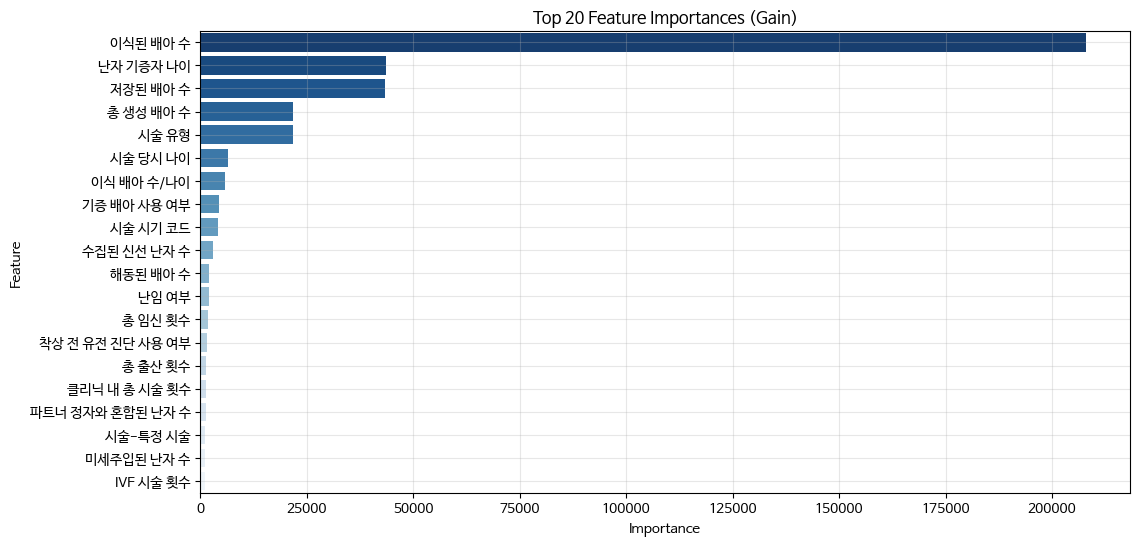

In [ ]:
plt.rc('font', family='NanumBarunGothic')
## Feature Importance 출력
feature_importance_ = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance(importance_type="gain")
})

feature_importance_ = feature_importance_.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_, palette="Blues_r")
plt.title("Top 20 Feature Importances (Gain)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(alpha=0.3)
plt.show()

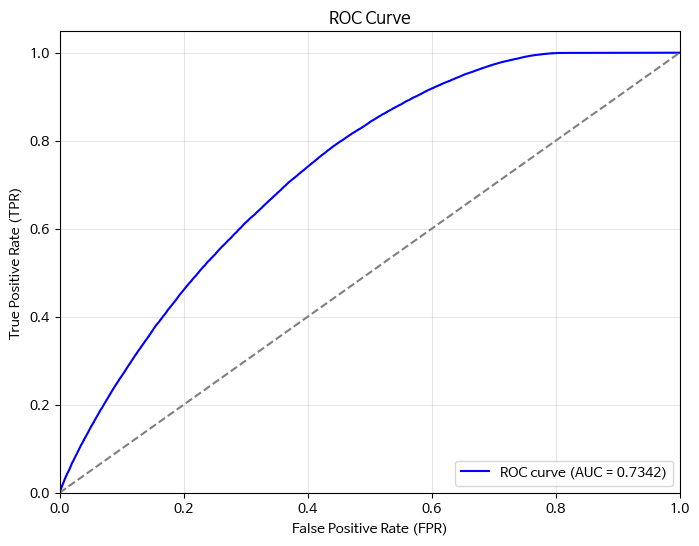

In [ ]:
from sklearn.metrics import roc_curve

# ROC 곡선 생성
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_pred_proba)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {np.mean(auc_scores):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from sklearn.utils import shuffle

def check_auc_impact(model, X_val, y_val, auc_original):
    auc_changes = {}

    for col in X_val.columns:
        X_shuffled = X_val.copy()
        X_shuffled[col] = shuffle(X_shuffled[col].values, random_state=42)  # 해당 컬럼 섞기

        y_pred_proba = model.predict(X_shuffled)
        auc_new = roc_auc_score(y_val, y_pred_proba)

        auc_changes[col] = auc_new - auc_original  # AUC 변화 저장

    auc_changes = sorted(auc_changes.items(), key=lambda x: x[1])  # AUC 변화 기준 정렬
    return auc_changes

# 기존 AUC
auc_original = roc_auc_score(y_val, model.predict(X_val))

# AUC 변화 확인
auc_changes = check_auc_impact(model, X_val, y_val, auc_original)
auc_changes

[('이식된 배아 수', -0.09339734229963592),
 ('난자 기증자 나이', -0.04671701455447619),
 ('저장된 배아 수', -0.023228843089465157),
 ('총 생성 배아 수', -0.02171754867899689),
 ('이식 배아 수/나이', -0.010004391536068247),
 ('수집된 신선 난자 수', -0.0031601904167815054),
 ('시술 시기 코드', -0.0023720410395071667),
 ('시술 당시 나이', -0.0021438517263976387),
 ('총 임신 횟수', -0.0017421066919488526),
 ('파트너 정자와 혼합된 난자 수', -0.0015382309652912651),
 ('미세주입된 난자 수', -0.001080295634149575),
 ('클리닉 내 총 시술 횟수', -0.000931007830622832),
 ('미세주입이 아닌 배아 이식 수', -0.0007977745394079916),
 ('시술 유형', -0.0007801742429350833),
 ('불임 원인 - 난관 질환', -0.0006617912018691552),
 ('총 출산 횟수', -0.000642482302608105),
 ('정자 출처', -0.0006390253851712435),
 ('미세주입이 아닌 배아 생성 수', -0.0005874913040954111),
 ('IVF 임신 횟수', -0.0004985685065728163),
 ('난임 여부', -0.000498256768469596),
 ('기증 배아 사용 여부', -0.0004754601750800447),
 ('불임 원인 - 남성 요인', -0.00038968354968749175),
 ('기증용', -0.0003845329214101634),
 ('Unknown', -0.0003645379997628817),
 ('미세주입에서 생성된 배아 수', -0.0003478431337042

In [ ]:
# '불임'이 포함된 컬럼 필터링
for col, change in auc_changes:
    if '이식' in col:
        print(f"{col}: {change:.4f}")


이식된 배아 수: -0.0934
이식 배아 수/나이: -0.0100
미세주입이 아닌 배아 이식 수: -0.0008
단일 배아 이식 여부: -0.0003
배아 이식 경과일: 0.0000
미세주입 배아 이식 수: 0.0000


## 최종 학습 제출

In [ ]:
### 🎯 **Sigmoid 변환을 이용한 앙상블**
def sigmoid_ensemble(predictions, weights=None):
    """ 클리핑 없이 Sigmoid 변환을 적용한 앙상블 """
    predictions = np.array(predictions)

    # Logit 변환: log(p / (1 - p))
    logit_values = np.log(predictions / (1 - predictions))

    # 가중 평균 (기본은 균등 가중치)
    if weights is None:
        result = np.mean(logit_values, axis=0)
    else:
        result = np.average(logit_values, weights=weights, axis=0)

    # 다시 Sigmoid 변환 적용하여 확률로 변환
    return 1 / (1 + np.exp(-result))

# Sigmoid 앙상블 적용
y_test_proba = sigmoid_ensemble(test_pred_proba_list)

In [ ]:
# 제출 파일 생성
submission_df = pd.read_csv("/content/drive/MyDrive/Aimers/data/sample_submission.csv")
submission_df['ID'] = test_ids
submission_df.iloc[:, 1] = y_test_proba
submission_df.to_csv('aimers_sub.csv', index=False)

from google.colab import files
files.download('aimers_sub.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 분석

## 분석1

In [ ]:
# 수치형 변수만 상관관계
corr_matrix = train_df.iloc[:,30:44].corr()
# 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

ValueError: could not convert string to float: '본인 제공'

In [ ]:
'''train_df['미세주입 배아 실패 난자'] = train_df['미세주입된 난자 수'] - train_df['미세주입에서 생성된 배아 수']
condition = (train_df['미세주입된 난자 수'] == -1) & (train_df['미세주입에서 생성된 배아 수'] == -1)
train_df.loc[condition, '미세주입 배아 실패 난자'] = -1
pd.crosstab(train_df['미세주입 배아 실패 난자'],train_df['임신 성공 여부'], normalize='index')'''

In [ ]:
'''train_df['이식률'] = train_df['이식된 배아 수'] / train_df['총 생성 배아 수']
train_df['이식률'] = train_df['이식률'].apply(lambda x: -1 if x < 0 else x)

train_df['이식률'].value_counts()'''

## 랜포

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

# Random Forest 하이퍼파라미터 설정
rf_params = {
    'n_estimators': 100,  # 트리 개수
    'max_depth': 10,  # 최대 깊이
    'random_state': 42,  # 랜덤 시드
    'class_weight': 'balanced',  # 클래스 불균형 조정
    'n_jobs': -1  # 병렬 처리
}

# K-Fold 설정
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 점수 저장 리스트
f1_scores, auc_scores, acc_scores = [], [], []

# K-Fold 검증
for train_idx, valid_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    # Random Forest 모델 학습
    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X_tr, y_tr)

    # Validation 데이터 예측
    y_pred_proba = rf_model.predict_proba(X_val)[:, 1]  # 확률 예측
    y_pred_binary = rf_model.predict(X_val)  # 클래스 예측

    # 점수 계산
    f1_scores.append(f1_score(y_val, y_pred_binary))
    auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    acc_scores.append(accuracy_score(y_val, y_pred_binary))

# 결과 출력
print(f"Mean F1-Score: {np.mean(f1_scores):.4f}")
print(f"Mean AUC: {np.mean(auc_scores):.4f}")
print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")


Mean F1-Score: 0.5083
Mean AUC: 0.7267
Mean Accuracy: 0.6199


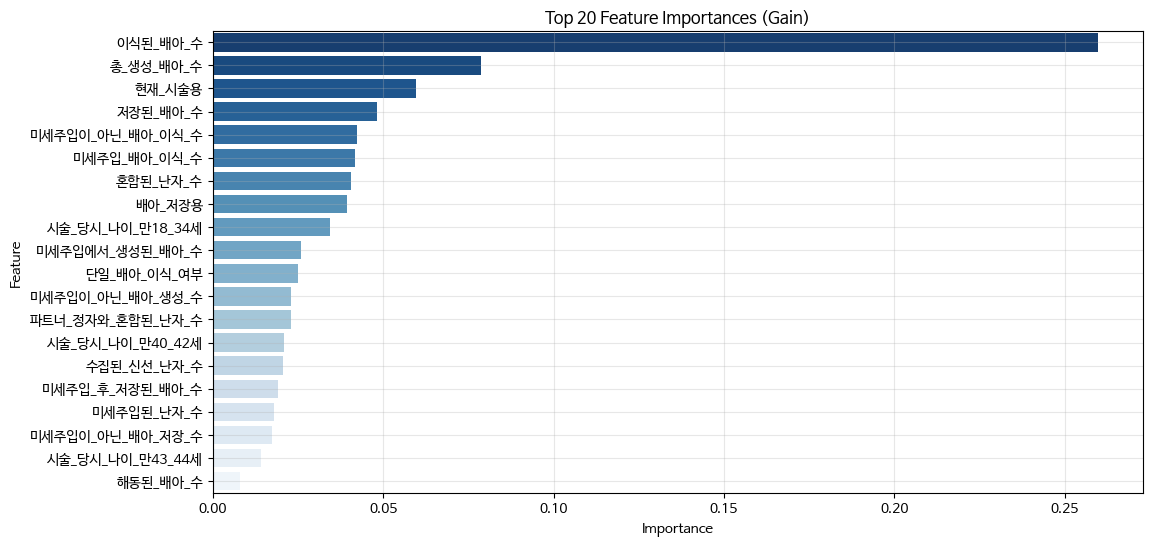

In [ ]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="Blues_r")
plt.title("Top 20 Feature Importances (Gain)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(alpha=0.3)
plt.show()

## 상관관계

In [ ]:
pd.set_option('display.max_rows', 100)

target_col = '임신 성공 여부'  # 상관관계를 확인할 컬럼명 지정
top_corr = corr_matrix[target_col].abs().nlargest(70).iloc[1:]  # 자기 자신 제외

print(top_corr)

이식된 배아 수             0.161762
시술 당시 나이             0.151900
총 생성 배아 수            0.148140
단일 배아 이식 여부          0.137179
현재 시술용               0.136844
혼합된 난자 수             0.118984
배아 저장용               0.115479
파트너 정자와 혼합된 난자 수     0.107920
미세주입에서 생성된 배아 수      0.092822
수집된 신선 난자 수          0.086336
미세주입 배아 이식 수         0.082668
미세주입이 아닌 배아 생성 수     0.078693
미세주입이 아닌 배아 이식 수     0.075551
미세주입된 난자 수           0.072848
난임 여부                0.067228
총 시술 횟수              0.060275
IVF 시술 횟수            0.058768
난자 저장용               0.053312
클리닉 내 총 시술 횟수        0.052922
난자 출처                0.048520
신선 배아 사용 여부          0.048229
기증 배아 사용 여부          0.042227
저장된 신선 난자 수          0.041750
시술 유형                0.040432
대리모 여부               0.038948
저장된 배아 수             0.038515
불임 원인 - 남성 요인        0.037976
PGS 검사를 받고도 안한 사람    0.032532
배란 자극 여부             0.031757
미세주입이 아닌 배아 저장 수     0.030138
기증자 정자와 혼합된 난자 수     0.028924
특정 시술 유형             0.026827
착상 전 유전 검사 사용 여부     0.026813
배아 이식 경과일 

In [ ]:
# prompt: 라벨 인코딩해서 상관관계 상위20개 출력
df = train_df.copy()

from sklearn.preprocessing import LabelEncoder

# Label Encoding
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# 상관관계 분석
corr_matrix = df.corr()


In [ ]:
pd.crosstab(df['이식된 배아 수'], df['임신 성공 여부'])

임신 성공 여부,0,1
이식된 배아 수,,
-1.0,5480,811
0.0,36514,30
1.0,64383,29408
2.0,76362,34483
3.0,7384,1496


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산 함수
def calculate_vif(df, target):
    df = df.drop(columns=[target], errors="ignore")  # 타겟 변수 제거
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)

# 타겟 변수명 설정
target_variable = '임신 성공 여부'

# VIF 계산
vif_result = calculate_vif(df, target_variable)

# 출력
print("Variance Inflation Factor (VIF):")
print(vif_result)

Variance Inflation Factor (VIF):
              Feature          VIF
32           이식된 배아 수          inf
31    미세주입에서 생성된 배아 수          inf
28           DI 출산 횟수          inf
27          IVF 출산 횟수          inf
26            총 출산 횟수          inf
25           DI 임신 횟수          inf
24          IVF 임신 횟수          inf
23            총 임신 횟수          inf
52          배아 이식 경과일          inf
20      클리닉 내 총 시술 횟수          inf
19            총 시술 횟수          inf
53          배아 해동 경과일          inf
54              난임 여부          inf
51          난자 혼합 경과일          inf
56   미세주입이 아닌 배아 이식 수          inf
57   미세주입이 아닌 배아 생성 수          inf
33       미세주입 배아 이식 수          inf
34           저장된 배아 수          inf
58   미세주입이 아닌 배아 저장 수          inf
35    미세주입 후 저장된 배아 수          inf
50          PGS 시술 여부          inf
49          PGD 시술 여부          inf
6    착상 전 유전 검사 사용 여부          inf
59      클리닉 외 총 시술 횟수          inf
60  PGS 검사를 받고도 안한 사람          inf
29          총 생성 배아 수          inf
2               시술 유형 

In [ ]:
# 상관관계 행렬에서 자기 자신과의 상관관계 및 중복 제거
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 상관관계가 높은 순으로 상위 20개 추출
top_20_corr_pairs = corr_pairs.unstack().dropna().abs().sort_values(ascending=False).head(40)

# 상위 20개의 상관관계 출력
print("Top 20 feature pairs with highest correlation:")
print(top_20_corr_pairs)

Top 20 feature pairs with highest correlation:
난자 혼합 경과일         PGD 시술 여부           1.000000
배아 해동 경과일         PGS 시술 여부           1.000000
배아 이식 경과일         착상 전 유전 검사 사용 여부    1.000000
IVF 임신 횟수         총 임신 횟수             0.962996
IVF 출산 횟수         총 출산 횟수             0.960738
난임 여부             총 시술 횟수             0.960180
미세주입에서 생성된 배아 수   미세주입된 난자 수          0.941089
대리모 여부            시술 유형               0.924973
파트너 정자와 혼합된 난자 수  혼합된 난자 수            0.916535
IVF 시술 횟수         총 시술 횟수             0.916159
부부 주 불임 원인        남성 주 불임 원인          0.914251
혼합된 난자 수          총 생성 배아 수           0.896275
부부 주 불임 원인        여성 주 불임 원인          0.892825
DI 출산 횟수          DI 임신 횟수            0.878279
혼합된 난자 수          수집된 신선 난자 수         0.877720
난임 여부             IVF 시술 횟수           0.870537
기증 배아 사용 여부       시술 유형               0.848517
여성 주 불임 원인        남성 주 불임 원인          0.841564
배아 해동 경과일         착상 전 유전 검사 사용 여부    0.841137
배아 이식 경과일         PGS 시술 여부           0.841137
배아 해동 경과일    

In [ ]:
# 상관관계 행렬에서 자기 자신과의 상관관계 및 중복 제거
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 상관관계가 높은 순으로 상위 20개 변수 쌍 추출
top_20_corr_pairs = corr_pairs.unstack().dropna().abs().sort_values(ascending=False).head(40)

# 변수 쌍 추출
top_20_feature_pairs = top_20_corr_pairs.index.tolist()

# 교차 테이블 및 시각화
for feature1, feature2 in top_20_feature_pairs:
    print(f"Cross-tabulation between {feature1} and {feature2}:\n")

    # 교차표 생성
    crosstab_result = pd.crosstab(df[feature1], df[feature2])
    display(crosstab_result, "\n")

## 후분석

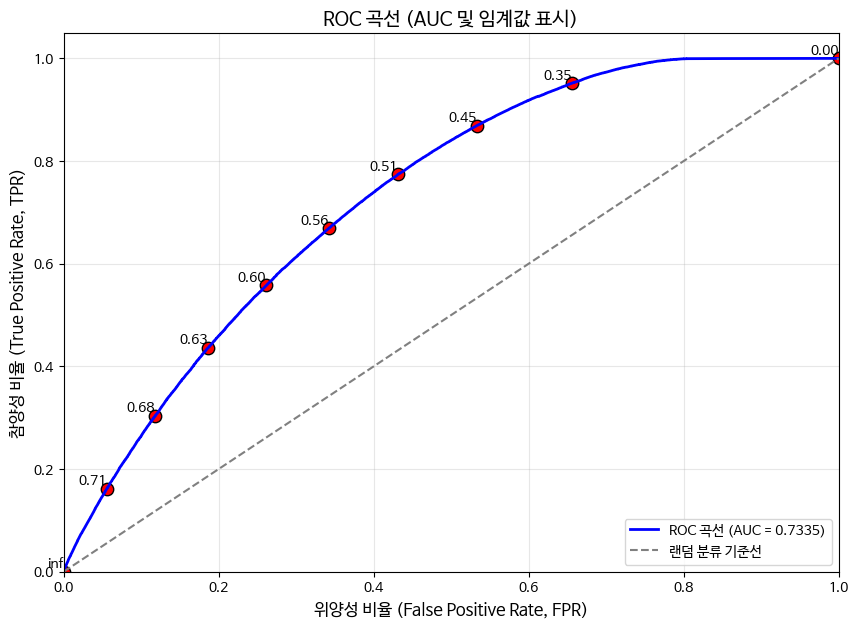

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_pred_proba)  # 전체 K-Fold 예측값 사용
roc_auc = roc_auc_score(all_y_true, all_y_pred_proba)

# ROC Curve 시각화
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC 곡선 (AUC = {roc_auc:.4f})')  # AUC 값 포함
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="랜덤 분류 기준선")  # 랜덤 분류기 기준선

# 주요 임계값(thresholds) 표시
threshold_points = np.linspace(0, len(thresholds) - 1, 10, dtype=int)  # 10개 지점 선택
for i in threshold_points:
    plt.scatter(fpr[i], tpr[i], marker='o', color='red', edgecolors='black', s=80)
    plt.text(fpr[i], tpr[i], f"{thresholds[i]:.2f}", fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# 축 및 제목 설정
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('위양성 비율 (False Positive Rate, FPR)', fontsize=12)
plt.ylabel('참양성 비율 (True Positive Rate, TPR)', fontsize=12)
plt.title('ROC 곡선 (AUC 및 임계값 표시)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# 그래프 출력
plt.show()


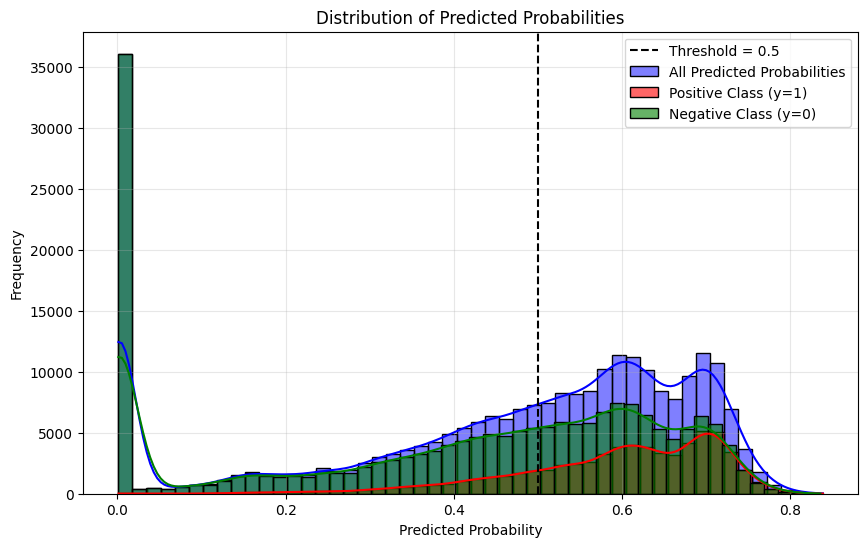

In [ ]:
## 확률값 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(all_y_pred_proba, bins=50, kde=True, color='blue', label='All Predicted Probabilities', alpha=0.5)
sns.histplot(np.array(all_y_pred_proba)[np.array(all_y_true) == 1], bins=50, kde=True, color='red', label='Positive Class (y=1)', alpha=0.6)
sns.histplot(np.array(all_y_pred_proba)[np.array(all_y_true) == 0], bins=50, kde=True, color='green', label='Negative Class (y=0)', alpha=0.6)
plt.axvline(0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.grid(alpha=0.3)
plt.show()